In [1]:
import sys
import os
import io
import json
import argparse
import numpy as np
import pandas as pd
import h5py
from pprint import pprint
from collections import OrderedDict
import processes.foundation as fd
import matplotlib.pyplot as plt
from scipy import stats
from math import exp
import processes.foundation as fd
import processes.fitModel as fM
import processes.histogramAction as hA
from math import exp, sqrt, pi, erfc
from lmfit import Model
import csv

from pygama import flow
from pygama.raw.build_raw import build_raw
from pygama.dsp.build_dsp import build_dsp

In [2]:
t2_data = fd.get_df(1124, 'Card1')

FileNotFoundError: file /home/jlb1694/data/dsp/Run1124.lh5 not found

In [ ]:
t2_data

(0.0, 600.0)

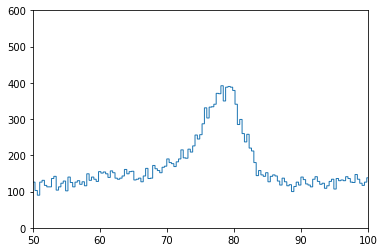

In [7]:
plt.hist(t2_data["trapEmax"], histtype="step", bins=160000)
plt.xlim(50,100)
plt.ylim(0,600)

In [2]:


file = '/home/jlb1694/processPygama/coherent.json'
with open(file, 'r') as read_file:
    data = json.load(read_file)

config = '/home/jlb1694/processPygama/configFiles/config.json'
with open(config, 'r') as read_file:
    configure = json.load(read_file)


chan_file = "/home/jlb1694/processPygama/chan_config.json"
conf_file = "/home/jlb1694/processPygama/dspConfigFiles/dsp_config.json"
with open(conf_file) as f:
    dsp = json.load(f, object_pairs_hook=OrderedDict)
with open(chan_file) as f:
    chan_conf = json.load(f, object_pairs_hook=OrderedDict)

fwMin = 100
riseMin = 0
flatMin = 0
FW = []
rise = []
flat = []
error = []

Processing table Card1: 100%|███████| 136426/136426 [00:35<00:00, 3798.36rows/s]
7.172007260143229
Processing table Card1:  47%|███▊    | 64000/136426 [00:16<00:19, 3788.86rows/s]

KeyboardInterrupt: 

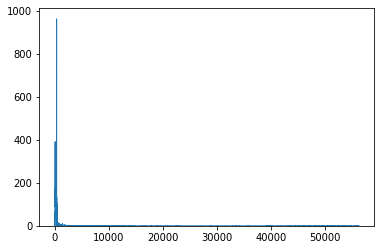

In [3]:
for i in range(6, 13):
        for j in np.arange(0.3,1.2, 0.1):

            dsp["processors"]["wf_trap"]["args"][1] = str(i) + '*us'
            dsp["processors"]["wf_trap"]["args"][2] = str(j) + '*us'

            json_object = json.dumps(dsp, indent=4)

        # Writing to sample.json
            with open(conf_file, "w") as outfile:
                outfile.write(json_object)


            dataFile = data['raw_dir'] + '/Run1124.lh5'
            outFile = data['dsp_dir'] + '/Run1124.lh5'

            build_dsp(dataFile, outFile, chan_config = chan_conf, write_mode = 'r')

            t2_data = fd.get_df(1124, 'Card1')

            counts, bins, bars = plt.hist(t2_data['trapEmax'], histtype='step', bins=160000)

            #lower and upper chosen by looking at spectrum above
            lower = hA.find_nearest_bin(bins,50)
            upper = hA.find_nearest_bin(bins,120)
            ydata = counts[lower:upper]
            xdata = bins[lower:upper]
            l = np.argmax(ydata)

            gmodel = Model(fM.lingaus)
            #params = gmodel.make_params(A=700, m1=315.5, s1=0.5, H_tail=-0.000001, H_step=1, tau=-0.5, slope=-6, intrcpt=180)
            params = gmodel.make_params(a1=1000, m1=xdata[l], s1=2.0, slope=-0.046, intrcpt=58)
            #params['s1'].vary = False
            result = gmodel.fit(ydata,params, x=xdata)

            sigma = result.params['s1'].value
            fw = 2.355*sigma
            try:
                FW.append(2.355*sigma)
                error.append(2.355*result.params['s1'].stderr)
                rise.append(i)
                flat.append(j)
            except:
                print('wierd')
            print(fw)

            if fw <= fwMin and fw >= 0:
                fwMin = fw
                riseMin = i
                flatMin = j

In [ ]:
i = fw.index(min(fw))
riMin = rise[i]
flatMin = flat[i]

indexRiMin = [i for i,x in enumerate(rise) if x==riMin]
fwRiMin = [fw[i] for i in indexRiMin]
flatRiMin = [flat[i] for i in indexRiMin]
errorRiMin = [error[i] for i in indexRiMin]
indexFlMin = [j for j,x in enumerate(flat) if x==flatMin]
fwFlatMin = [fw[i] for i in indexFlMin]
riseFlMin = [rise[i] for i in indexFlMin]
errorFlMin = [error[i] for i in indexFlMin]

In [ ]:
plt.subplot(1,2,1)
plt.errorbar(flatRiMin,fwRiMin,yerr=errorRiMin, fmt='o')
plt.title("FWHM vs flat time for pulser peak with rise time 10.0 us")
plt.xlabel("shaping (microseconds)")
plt.ylabel("FWHM (KeV)")
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(1,2,2)
plt.errorbar(riseFlMin,fwFlatMin,yerr=errorFlMin, fmt='o')
plt.title("FWHM vs flat time for pulser peak with rise time 10.0 us")
plt.xlabel("shaping (microseconds)")
plt.ylabel("FWHM (KeV)")
plt.rcParams['figure.facecolor'] = 'white'
plt.show()